In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Reload Data & Baseline Model

In [2]:
#load the dataset
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing( as_frame=True )
df= housing.frame

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


# Step 2: Explore Feature Correlations

Now that we’ve loaded the California Housing dataset into df (where each column is a feature like MedInc, HouseAge, etc., plus our target MedHouseVal), we want to see how strongly each feature relates to the target.

Why this matters
Strongly correlated features (positively or negatively) are usually more useful for predictions.

Weakly correlated features can still be useful (especially for non-linear models), but this step helps us understand the dataset better.

We can also check if some features are correlated with each other, which could cause redundancy (multicollinearity).

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

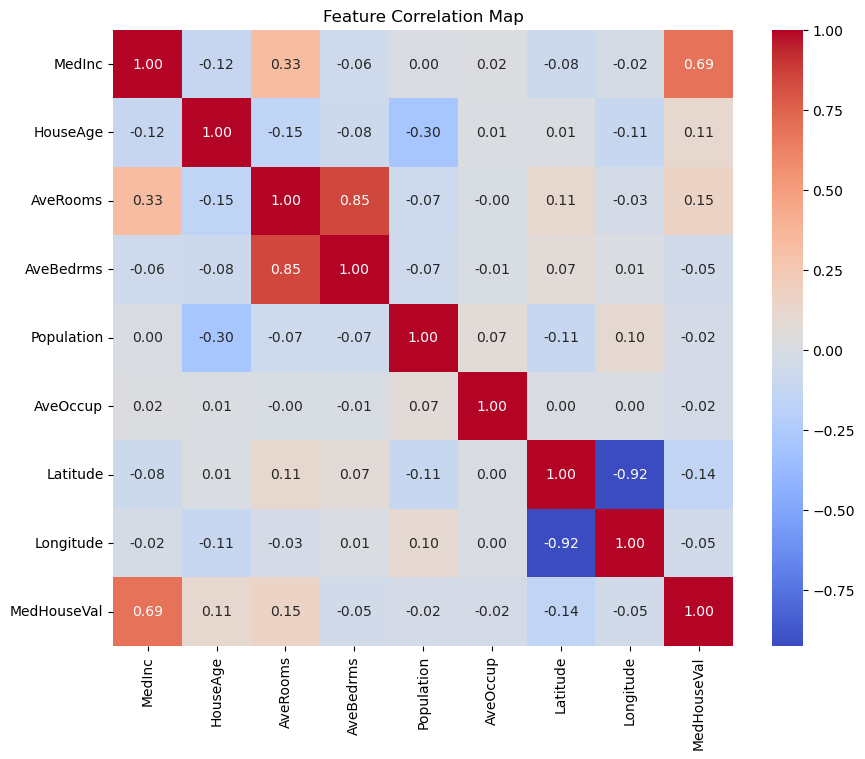

In [10]:
#compute correlation matrix
corr_matrix = df.corr()

#visualize as heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f')
plt.title("Feature Correlation Map")
plt.show()

In [12]:
#Sort features by correaltion with target
target_corr= corr_matrix["MedHouseVal"].sort_values(ascending=False)
print("Correlation with Target:\n",target_corr)

Correlation with Target:
 MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64


Here’s what we’ve learned from correlation output:

Strongest positive correlation → MedInc (Median Income) with 0.688

Moderate positive correlation → AveRooms with 0.152

Weak positive correlation → HouseAge with 0.106

Negative correlations → Latitude, AveBedrms, Longitude, Population, AveOccup (most are very weak)

# Step 3: Feature Selection & Scaling
Right now, your correlation results tell us which features are most strongly related to the target (MedHouseVal).

We can improve the model in three layers:
## 1️⃣ Feature Engineering
- Use only the most relevant features (those with higher absolute correlation to MedHouseVal).
- Try polynomial features for MedInc (since it has the highest correlation).
- Create interaction terms (e.g., MedInc × HouseAge) to capture combined effects.

## 2️⃣ Model Selection
Instead of just LinearRegression, try:
- Ridge (to reduce overfitting by penalizing large coefficients).
- Lasso (to shrink coefficients of unimportant features to zero).
- RandomForestRegressor (non-linear model to capture complex patterns).

## 3️⃣ Model Evaluation & Tuning
- Use cross-validation to get a reliable performance measure.
- Tune hyperparameters (e.g., number of trees in Random Forest).
- Compare models with metrics like R² and RMSE.

## Step 1: Feature Selection & Engineering
We’ll keep the top 4–6 features to test performance.
Since MedInc has the strongest relationship with the target, we’ll create MedInc² to capture any curved (non-linear) relationship.
We’ll create a smaller dataset with only these features + the polynomial term.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

#select top features
top_features = ['MedInc', 'AveRooms', 'HouseAge', 'AveBedrms', 'Latitude', 'Longitude']
X_selected = df[top_features]
y = df['MedHouseVal']

#Create polynomial feature for MedInc
poly = PolynomialFeatures(degree=2, include_bias=False)
medinc_poly = poly.fit_transform(X_selected[['MedInc']])
medinc_poly_df= pd.DataFrame(medinc_poly, columns= ['MedInc', 'MedInc^2'])

#Replace original medinc column with the two new columns
X_engineered = pd.concat([medinc_poly_df, X_selected.drop(columns=['MedInc'])], axis=1)

print(X_engineered.head())

   MedInc   MedInc^2  AveRooms  HouseAge  AveBedrms  Latitude  Longitude
0  8.3252  69.308955  6.984127      41.0   1.023810     37.88    -122.23
1  8.3014  68.913242  6.238137      21.0   0.971880     37.86    -122.22
2  7.2574  52.669855  8.288136      52.0   1.073446     37.85    -122.24
3  5.6431  31.844578  5.817352      52.0   1.073059     37.85    -122.25
4  3.8462  14.793254  6.281853      52.0   1.081081     37.85    -122.25


The next step is to train the model with this updated feature set to see if performance improves.

In [18]:
# Train-test split
X_train, X_test, y_train, y_test= train_test_split(X_selected,y,test_size=0.2,random_state=42)

#train model
model= LinearRegression()
model.fit(X_train,y_train)

#predictions
y_pred= model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.556963937855082
RMSE: 0.7463001660559121
